In [1]:
import pandas as pd
import numpy as np
import hilbert
import ipaddress
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dtype = {
    'network' : 'string',
    'country_name' : 'string',
    'subdivision_1_name' : 'string',
    'city_name' : 'string',
}

file_name = '/Users/farwah/Harman/NNSys/IP/data/merged_ip_lite.csv'

df = pd.read_csv(file_name, dtype=dtype)
df.head()

,network,country_name,subdivision_1_name,city_name
0,1.0.0.0/24,Australia,<NA>,<NA>
1,1.1.1.4/30,Australia,<NA>,<NA>
2,1.1.1.8/29,Australia,<NA>,<NA>
3,1.1.1.16/28,Australia,<NA>,<NA>
4,1.1.1.32/27,Australia,<NA>,<NA>


In [3]:
def ip2int(ip: str, octet: int) -> np.int32:
    parts = ip.split('.')
    integer = 0

    for i in range(octet - 1, -1, -1):
        index = octet - i - 1
        integer += int(parts[index]) << (8 * i)
    return integer

def networks2int(networks, octet):
    integers = np.array([], dtype=np.int32)

    for network in tqdm(networks):
        start_address, end_address = str(ipaddress.IPv4Network(network)[0]), str(ipaddress.IPv4Network(network)[-1])
        start_integer, end_integer = ip2int(start_address, octet=octet), ip2int(end_address, octet=octet)

        _tmp = np.arange(start_integer, end_integer + 1, dtype=np.int32)
        integers = np.concatenate((integers, _tmp), dtype=np.int32)
    return np.unique(integers)

In [4]:
### POSITIVE CLASS
country = "Japan"
octet = 3
pos_networks = df[df.country_name == country]['network'].to_numpy()
pos_ips = networks2int(pos_networks, octet=octet)

100%|█████████████████████████████████| 138976/138976 [00:34<00:00, 4050.69it/s]


In [5]:
negative_universe = np.arange(0, 2**(octet*8), dtype=np.int32)
neg_ips = np.random.choice(negative_universe, replace=False, size=(int(1.5*len(pos_ips))))
neg_ips = neg_ips[np.in1d(neg_ips, pos_ips, invert=True)]

In [6]:
len(pos_ips) / (len(neg_ips) + len(pos_ips))

0.4114922505903897

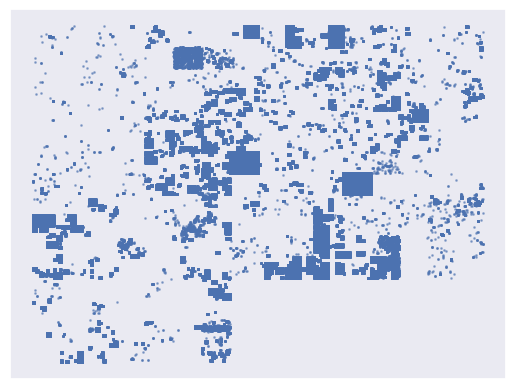

In [10]:
pos_coords = hilbert.decode(pos_ips, num_dims=2, num_bits=octet * 4)

plt.scatter(pos_coords[:, 0],pos_coords[:, 1],s=1, alpha=0.5, label="Positive")
plt.xticks([])
plt.yticks([])
plt.savefig(f'figures/{country}_ground_truth')
dpi = 300
plt.savefig(f'figures/{country}_ground_truth_dpi_{dpi}', dpi=dpi)
plt.show()

In [11]:
dataset = pd.DataFrame({
    'integer' : np.concatenate((pos_ips, neg_ips), dtype=np.int32),
    'label' : np.concatenate((np.ones_like(pos_ips), np.zeros_like(neg_ips)))
})